In [1]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from helper_functions import *
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import LinearSegmentedColormap
warnings.filterwarnings('ignore')

### Load data and prepare data

In [2]:
df = pd.read_csv('../datasets/data/bar_pass_prediction.csv', index_col=False)
print(df.shape)
df = df.dropna()
print(df.columns)
display(df.head())

(22407, 39)
Index(['decile1b', 'decile3', 'ID', 'decile1', 'sex', 'race', 'cluster',
       'lsat', 'ugpa', 'zfygpa', 'DOB_yr', 'grad', 'zgpa', 'bar1', 'bar1_yr',
       'bar2', 'bar2_yr', 'fulltime', 'fam_inc', 'age', 'gender', 'parttime',
       'male', 'race1', 'race2', 'Dropout', 'other', 'asian', 'black', 'hisp',
       'pass_bar', 'bar', 'bar_passed', 'tier', 'index6040', 'indxgrp',
       'indxgrp2', 'dnn_bar_pass_prediction', 'gpa'],
      dtype='object')


,decile1b,decile3,ID,decile1,sex,race,cluster,lsat,ugpa,zfygpa,...,hisp,pass_bar,bar,bar_passed,tier,index6040,indxgrp,indxgrp2,dnn_bar_pass_prediction,gpa
0,10.0,10.0,2,10.0,1.0,7.0,1.0,44.0,3.5,1.33,...,0,1,a Passed 1st time,True,4.0,886.842082,g 700+,i 820+,0.979804,3.5
1,5.0,4.0,3,5.0,1.0,7.0,2.0,29.0,3.5,-0.11,...,0,1,a Passed 1st time,True,2.0,649.999987,f 640-700,f 640-700,0.979804,3.5
2,3.0,2.0,36,3.0,2.0,7.0,3.0,36.0,3.5,-0.64,...,0,1,a Passed 1st time,True,3.0,760.526298,g 700+,h 760-820,0.979804,3.5
3,7.0,4.0,52,7.0,2.0,7.0,3.0,39.0,3.5,0.34,...,0,1,a Passed 1st time,True,3.0,807.894717,g 700+,h 760-820,0.979804,3.5
4,9.0,8.0,55,9.0,2.0,7.0,4.0,48.0,3.5,1.02,...,0,1,a Passed 1st time,True,5.0,949.999974,g 700+,i 820+,0.979804,3.5


**UI text #1**

A subset of the [Law School Admission Bar*](https://www.kaggle.com/datasets/danofer/law-school-admissions-bar-passage) dataset is used as a demo. Synthetic data will be generated for the following columns: 

- sex: student gender, i.e. 1 (male), 2 (female)
- race1: race, i.e. asian, black, hispanic, white, other
- ugpa: The student's undergraduate GPA, continous variable;
- bar: Ground truth label indicating whether or not the student passed the bar, i.e. passed 1st time, passed 2nd time, failed, non-graduated

The CART method will be used  evaluate the distribution and correlation differences between the real and synthetic data.

*The original paper can be found [here](https://files.eric.ed.gov/fulltext/ED469370.pdf).

In [3]:
# demo dataset
original_data = df[['sex', 'race1', 'ugpa', 'bar']]
original_data.head()

,sex,race1,ugpa,bar
0,1.0,white,3.5,a Passed 1st time
1,1.0,white,3.5,a Passed 1st time
2,2.0,white,3.5,a Passed 1st time
3,2.0,white,3.5,a Passed 1st time
4,2.0,white,3.5,a Passed 1st time


### 1. Data types detection

In [4]:
# get the data types of columns using helper function
dtypes_dict = data_type(original_data)
dtypes_dict

{'sex': 'float', 'race1': 'category', 'ugpa': 'float', 'bar': 'category'}

In [5]:
# automatically detect the data type of each column
dtypes_dict = original_data.dtypes.to_dict()
dtypes_dict

{'sex': dtype('float64'),
 'race1': dtype('O'),
 'ugpa': dtype('float64'),
 'bar': dtype('O')}

In [6]:
# replace 'float64' with 'float' and 'O' with 'object'
dtypes_dict = {k: 'float' if v == 'float64' else 'category' if v == 'O' else v for k, v in dtypes_dict.items()}
dtypes_dict

## UI text
print('Per column in the uploaded data, the following data types were detected:')
for key, value in dtypes_dict.items():
    print(f'{key}: {value}')

Per column in the uploaded data, the following data types were detected:
sex: float
race1: category
ugpa: float
bar: category


In [7]:
# Encode string columns to numeric values
label_encoders = {}
real_data = original_data.copy()
for column in original_data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    real_data[column] = label_encoders[column].fit_transform(original_data[column])

real_data.head()

,sex,race1,ugpa,bar
0,1.0,4,3.5,0
1,1.0,4,3.5,0
2,2.0,4,3.5,0
3,2.0,4,3.5,0
4,2.0,4,3.5,0


### 2. Gaussian copula model

**UI text #3**

Gaussian copula (GC) is a statitical method to generata synthetic data that mimic the structure and relationships (dependencies) seen in real data. It works well when the data has relationships between variables that need to be preserved, even if the exact data values change. A 'copula' helps describe how these variables are connected or correlated without focusing on their actual values. The Gaussian Copula specifically uses a normal distribution to model these connections.

GC works in two main steps:
1. The real data is transformed into a uniform distribution. Correlations between variables are modeled using a multivariate normal distribution (the *Gaussian copula*);
2. Synthetic data is created by sampling from this Gaussian copula and transforming the samples back to the original data distributions.

Based on the above histogram plots, one should consider whether the univariate distibution follow approximately a normal disctribution.

In [8]:
# Initialize synthesizer and fit it to the data
synthesizer = GaussianCopulaSynthesizer()
synthesizer.fit(real_data)

In [9]:
# Generate synthetic data
n_synth_data = real_data.shape[0]
synth_df = synthesizer.sample(n_synth_data)

### 3. Evaluation of generated data

In [10]:
# combine original data and decoded synthetic data in dataframe
combined_data = pd.concat((df.assign(realOrSynthetic='real'), synth_df.assign(realOrSynthetic='synthetic')), keys=['real','synthetic'], names=['Data'])

#### 3.1 Univariate distribution

**UI text #4**

{NUMBER_OF_SYNTH_DATA} synthetic data points are generated using CART. The figures below display the diffeneces in value frequency for each variable. A grey bar chart indicates the amount of values is equally represented in the synthetic data and in the real data. A bar chart with an organge top indicates that the synthetic data containes more values for this variable compared to the real data. Conversely, a bar chart with a blue top shows that the synthetic data contains fewer values for this variable than the real data.

In [11]:
# combine original data and decoded synthetic data in dataframe
combined_data = pd.concat((df.assign(realOrSynthetic='real'), synth_df.assign(realOrSynthetic='synthetic')), keys=['real','synthetic'], names=['Data'])

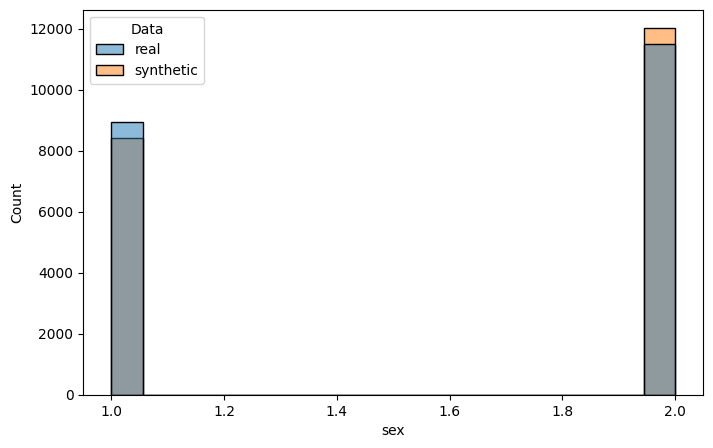

race1


TypeError: 'value' must be an instance of str or bytes, not a float

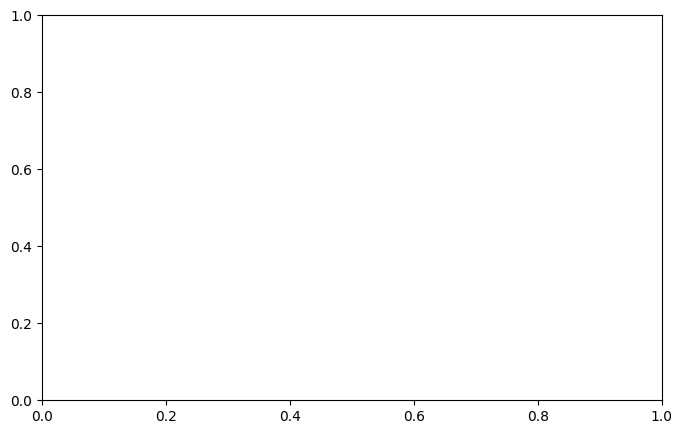

In [12]:
for column_name in real_data.columns:
    if dtypes_dict[column_name]=='float':
        plt.figure(figsize=(8, 5))
        sns.histplot(data=combined_data,
                     x= column_name,
                     stat="count",
                     hue='Data'
                     )
        plt.show()
    else:
        print(column_name)
        plt.figure(figsize=(8, 5))
        sns.histplot(data=combined_data,
                     x= column_name,
                     stat="count",
                     hue='Data',
                     discrete=True
                     )
        plt.show()

#### 3.2 Bivariate distributions

**UI text #5**

The figures below display the differences in value frequency for a combination of variables. A grey bar chart indicates the amount of values is equally represented in the synthetic data and in the real data. A bar chart with an orange top indicates that the synthetic data containes more values for this variable compared to the real data. Conversely, a bar chart with a blue top shows that the synthetic data contains fewer values for this variable than the real data.

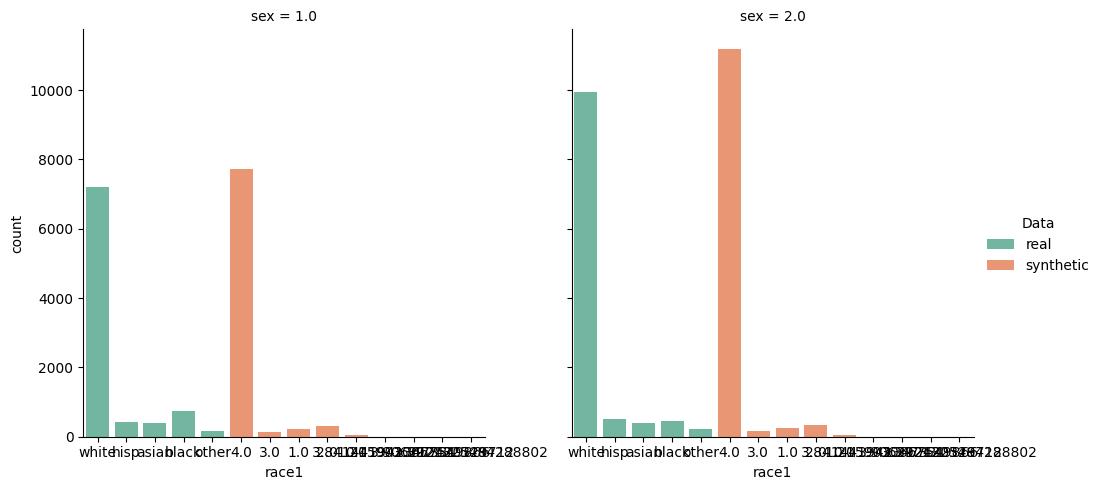

In [13]:
column_name1 = 'sex'
column_name2 = 'race1'

sns.catplot(x=column_name2,
    hue="Data",
    col=column_name1,
    data=combined_data,
    kind="count",
    palette='Set2')

#### 3.3 Correlation matrices

**UI text**

The matrix below illustrates the differences in pairwise correlations between variables in the original and synthetic data. Green cells signify that the pairwise correlation was accurately captured, with 0 representing the best possible score. Red cells indicate poor capture of the pairwise correlation, with scores of -2 and 2 representing the worst possible outcomes.

Text(0.5, 1.0, 'Difference in correlation matrix (real data - synthetic data)')

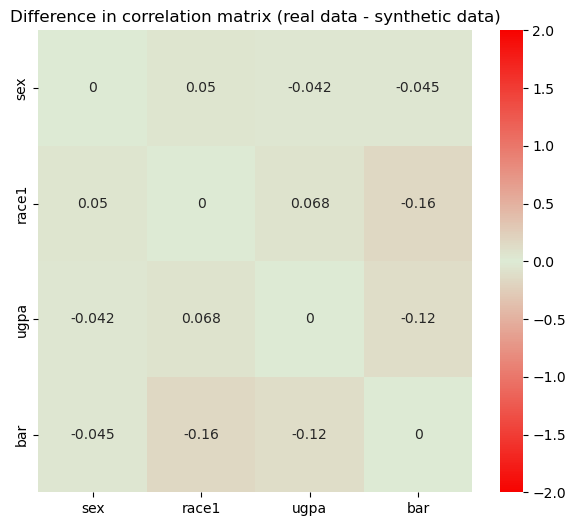

In [14]:
plt.figure(figsize=(7, 6))

# Plot correlation matrix for real_data

# Define custom colormap
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#f70300', '#ddebd5', '#f70300'])

# Plot correlation matrix for real_data
sns.heatmap(real_data.corr()-synth_data.corr(), annot=True, cmap=cmap, vmin=-2, vmax=2)
plt.title('Difference in correlation matrix (real data - synthetic data)')

#### 3.3 Kolmogorov-Smirnov Test for numerical columns

**UI-text**

For numerical columns, The KSComplement returns 1-(KS statistics) where the Kolmogorov Smirnov (KS) statistic is the maximal difference between the CDF of the variable in the original and the synthetic data. A value close to 1 represents a better fit.

In [15]:
real_data.dtypes

sex      float64
race1      int64
ugpa     float64
bar        int64
dtype: object

In [16]:
for column in real_data.select_dtypes(include=['float64', 'int64']).columns:
    ks_stat, p_value = ks_2samp(real_data[column], synth_data[column])
    print(f'KS Test for {column}: KS Statistic = {ks_stat}, p-value = {p_value}')

KS Test for sex: KS Statistic = 0.023253536985362533, p-value = 3.137761629399393e-05
KS Test for race1: KS Statistic = 0.08425123610907133, p-value = 1.599687130750092e-63
KS Test for ugpa: KS Statistic = 0.005678758505899051, p-value = 0.8948988548154176
KS Test for bar: KS Statistic = 0.08963626572673422, p-value = 7.363951346937228e-72


#### 3.4 Chi-Square Test for categorical columns

For categorical columns, The TVComplement returns 1 - (TV Distance), where the Total Variation Distance measures the relative frequencies of the categories of a given variable in the original and the synthetic data. A value close to 1 represents a better fit

In [17]:
for column in real_data.select_dtypes(include=['category']).columns:
    contingency_table = pd.crosstab(real_data[column], synth_data[column])
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    print(f'Chi-Square Test for {column}: Chi2 Statistic = {chi2_stat}, p-value = {p_value}')

In [18]:
# old
run_diagnostic(real_data, synth_data, target_column='gpa')

{'distribution_results': {'sex': {'ks_stat': 0.023253536985362533,
   'p_value': 3.137761629399393e-05},
  'race1': {'ks_stat': 0.08425123610907133, 'p_value': 1.599687130750092e-63},
  'ugpa': {'ks_stat': 0.005678758505899051, 'p_value': 0.8948988548154176},
  'bar': {'ks_stat': 0.08963626572673422, 'p_value': 7.363951346937228e-72}},
 'correlation_diff': 0.060654318035029894}